### 9e december

# Tidsserier

- RL:
    - Vi har ingen historisk data
    - Vi lär oss allt eftersom
    - Morot och piska för rätt och fel
    - Två parallella nätverk som syncar lite med varandra
        - "gammal" teknik (10 år)

- Tidsserie
    - En datamängd samlad över tid. Typ aktier, elkonsumtion mm.
    - Metrologi:

In [1]:
import pandas as pd
import numpy as np
import os

fname = '../data/jena_climate.csv'

with open(fname, "r") as f:
    data = f.read()
    
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

In [2]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
num_test_samples, num_val_samples, num_train_samples

(105114, 105112, 210225)

In [3]:
# Värdena har inte med varandra att göra, så vi måste scalera datan

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [4]:
import keras
from keras import layers

In [5]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    temperature[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
    shuffle=True,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    temperature[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
    shuffle=True,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    temperature[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
    shuffle=True,
    start_index=num_train_samples + num_val_samples
)

In [6]:
train_dataset.element_spec

(TensorSpec(shape=(None, None, 14), dtype=tf.float64, name=None),
 TensorSpec(shape=(None,), dtype=tf.float64, name=None))

In [7]:
for samples, targets in train_dataset.take(1):
    print(samples.shape, targets.shape)

(256, 120, 14) (256,)


In [8]:
header

['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

In [9]:
def evaluate_naive_method(dataset):
    total_abs_err = float(0)
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

In [10]:
print(f"validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"test MAE: {evaluate_naive_method(test_dataset):.2f}")

validation MAE: 2.44
test MAE: 2.62


In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# x = layers.Flatten()(inputs)
x = layers.Dense(16, activation='relu')(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
    ]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])


Epoch 1/20


819/819 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - loss: 106.9930 - mae: 8.3748 - val_loss: 66.0099 - val_mae: 6.6844
Epoch 2/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - loss: 76.6655 - mae: 7.0940 - val_loss: 65.4243 - val_mae: 6.6579
Epoch 3/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - loss: 76.4684 - mae: 7.0847 - val_loss: 65.5519 - val_mae: 6.6649
Epoch 4/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - loss: 76.4102 - mae: 7.0823 - val_loss: 65.4198 - val_mae: 6.6582
Epoch 5/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - loss: 76.4911 - mae: 7.0860 - val_loss: 65.6772 - val_mae: 6.6712
Epoch 6/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - loss: 76.4326 - mae: 7.0838 - val_loss: 65.7984 - val_mae: 6.6772
Epoch 7/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - loss: 76.4434 - mae: 7.0832 - val_loss: 65.1898 - val_mae: 6.6462
Epoch 8/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - loss: 76.4134 - mae: 7.0826 - val_loss: 65.4650 - val_mae: 6.6606
Epoch 9/20
819/819 ━━━━━━━━━━━━━━━

In [ ]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)
model = keras.models.load_model("jena_dense.keras")

In [13]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 65.5384 - mae: 6.6255
Test MAE: 6.64


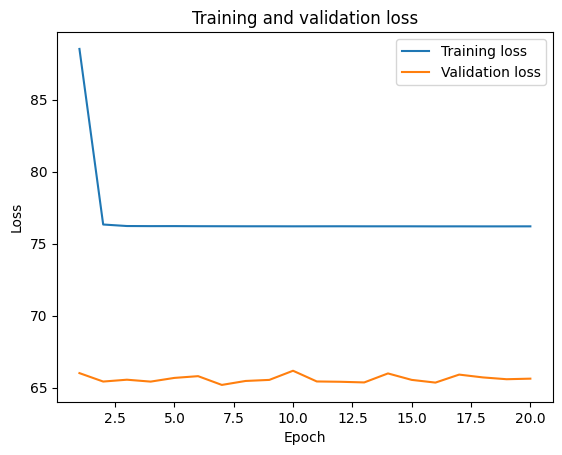

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(range(1, len(loss) + 1), loss, label='Training loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [23]:
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 38s 47ms/step - loss: 16.2294 - mae: 3.1015 - val_loss: 9.3008 - val_mae: 2.3810
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - loss: 15.9153 - mae: 3.0783 - val_loss: 9.0528 - val_mae: 2.3467
Epoch 3/50
334/819 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 15.7285 - mae: 3.0648

KeyboardInterrupt: 

In [ ]:
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 10.6648 - mae: 2.5457
Test MAE: 2.54


In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(range(1, len(loss) + 1), loss, label='Training loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()